# Práctica 1 - Self-Organising Maps
## Preparación de entorno
#### Instalar las librerías

In [2]:
# %pip install numpy
# %pip install matplotlib

#### Importar librerías de código

In [1]:
%reset
# from __future__ import division

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from mpl_toolkits.mplot3d import Axes3D

# Permite que los gráficos sean interactivos en el notebook
%matplotlib inline

Nothing done.


## SOM Setup
* **SOM** $\rightarrow$ Red neuronal no supervisada que reduce la dimensionalidad de los datos y los visualiza en un mapa 2D (Mapa autoorganizado).
  * Vector de entrada $\rightarrow$ Se le va presentando al SOM y ajusta sus pesos con estos vectores.
  * Autoorganización $\rightarrow$ Las neuroinas que repsonden de forma siilar a cierta entrada se agrupan.
  * Aprendizaje y ajuste $\rightarrow$ Durante el entrenamiento, la red modifica los donde cada mapa se especializa en un patrón específico.
* **Matriz de pesos** $\rightarrow$ Matriz multidimensionl de neuronas que procesea patrones que vienen de un array de neuronas de entrada.
  * Se inicializa con valores aleatorios (no a partir del vector de entrada, si no que se van ajustando a lo largo del entrenamiento).
* ***Best Matching Unit (BMU)*** $\rightarrow$ Neurona que tiene el vector de pesos más similar al vector de entrada.
  * El aprendizaje se basa en la actualización de los pesos de la BMU y de las neuronas vecinas.
  * Los pesos de la BMU se ajustan/actualizan para acercarse al vector de entrada.
* **Vecindad** $\rightarrow$ Neuronas adyacentes a la BMU (es una región de la matriz de pesos).
  * Las neuronas de la vecindad también se ajustan, pero en menor medida que la BMU.
* ***Learning Rate (LR)*** $\rightarrow$ Factor que determina cuánto se ajustan los pesos de la BMU y de las neuronas vecinas.
  * Se reduce a lo largo del tiempo para que el ajuste sea más preciso.
  * Disminuye a medida que nos alejamos de la BMU.

> *Nota* - El SOM aprende a ordenar la matriz de pesos para que reperesente la estructura inherente a los datos de entrada.

In [3]:
lado_mapa = 50
"""Tamaño del mapa de Kohonen (lado_mapa x lado_mapa)"""

periodo = 2000
"""Número total de iteraciones del entrenamiento"""

learning_rate = 0.15
"""Tasa de aprendizaje inicial (cuanto se modifica el peso en cada iteración)"""

normalizar_datos = True
"""Indica si hay que normalizar los datos o no"""

vecindario = lado_mapa // 2
"""Radio de influenia alrededor de la neurona ganadora"""

dataset_path = "pokemon_train.csv"
datos_original = pd.read_csv(dataset_path)
"""Contiene todos los datos disponibles de cada Pokemon"""

tipos_pokemon = datos_original[['type1', 'type2']].fillna('-').to_numpy()

columnas_relevantes = [col for col in datos_original.columns if "against_" in col]
datos = datos_original[columnas_relevantes].values
"""Filtramos obteniendo únicamente las columnas de cómo reaccionan ante los ataques de los tipos de Pokemon"""

valor_maximo = datos.max(axis=0)
"""Valor máximo de los datos de entrada"""

if normalizar_datos:
    # Escalamos los datos al rango [0, 1]
    datos = datos / np.max(valor_maximo)

num_datos = datos.shape[0]
"""Cantidad de muestras de pokemons que usaremos para entrenar el SOM"""

num_entradas = datos.shape[1]
"""Dimensionalidad de los datos de entrada"""

print(f"Datos cargados: {num_datos} patrones, {num_entradas} dimensiones.")

matriz_pesos = np.random.random((lado_mapa, lado_mapa, num_entradas))
"""Matriz de pesos de las neuronas"""

C:\Users\david\AppData\Local\Temp\ipykernel_9292\1307945679.py:22: RuntimeWarning: assigning None to unbound local 'col'
  columnas_relevantes = [col for col in datos_original.columns if "against_" in col]
C:\Users\david\AppData\Local\Temp\ipykernel_9292\1307945679.py:22: RuntimeWarning: assigning None to unbound local 'col'
  columnas_relevantes = [col for col in datos_original.columns if "against_" in col]
C:\Users\david\AppData\Local\Temp\ipykernel_9292\1307945679.py:22: RuntimeWarning: assigning None to unbound local 'col'
  columnas_relevantes = [col for col in datos_original.columns if "against_" in col]
C:\Users\david\AppData\Local\Temp\ipykernel_9292\1307945679.py:22: RuntimeWarning: assigning None to unbound local 'col'
  columnas_relevantes = [col for col in datos_original.columns if "against_" in col]


Datos cargados: 247 patrones, 18 dimensiones.


'Matriz de pesos de las neuronas'

#### Funciones para entrenar/clasificar
##### Distancia euclídea

La distancia euclídea se define como la raíz cuadrada de la suma de las diferencias al cuadrado de cada componente de los vectores. Tenemos que calcularlo para vectores RGB, por lo que la fórmula es la siguiente:
$$\text{distancia euclídea} = \sqrt{(R_{entrada} - R_{actual})^2 + (G_{entrada} - G_{actual})^2 + (B_{entrada} - B_{actual})^2}$$

In [8]:
def calcular_bmu(patron_entrada, matriz_pesos, num_entradas) -> tuple:
   """Encuentra la BMU (neurona ganadora) para un patrón de entrada.

   Args:
      patron_entrada: Vector de entrada de un pokemon y sus reacciones ante ataques normalizado
      matriz_pesos: Matriz de pesos de las neuronas del SOM
      num_entradas: Dimensionalidad de los datos de entrada (18, 1 por cada tipo)

   Returns:
      tuple (bmu, bmu_idx):
         - bmu: vector de pesos de la neurona ganadora
         - bmu_idx: coordenadas [x,y] de la neurona ganadora
   """

   distancia_minima = float('inf')
   bmu = np.zeros(num_entradas)
   bmu_idx = np.zeros(2)

   # Recorremos cada neurona para encontrar la BMU
   # Filas -> matriz_pesos.shape[0]
   # Columnas -> matriz_pesos.shape[1]
   for fila in range(matriz_pesos.shape[0]):
      for columna in range(matriz_pesos.shape[1]):
         peso_actual = matriz_pesos[fila, columna]

         # Calculamos la distancia euclídea entre el peso actual y el patrón de entrada
         distancia = np.linalg.norm(patron_entrada - peso_actual)

         if distancia < distancia_minima:
            distancia_minima = distancia
            bmu = peso_actual
            bmu_idx = np.array([fila, columna])

   return bmu, bmu_idx

##### Learning Rate

El learning rate es un valor que se va reduciendo a medida que se va entrenando la red. Controla cuánto se modifican los pesos y determina el temaño del ajuste en los pesos de las neuronas. Se calcula usando una función de decaimiento lineal:
$$\alpha(t) = \alpha_0 \cdot \left ( 1 - \frac{t}{T} \right)$$

Donde:
* $\alpha_0$: Learning rate inicial.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\alpha(t)$: Learning rate en la iteración $t$.

¿Porque usamos el decaimiento lineal?:
1. **Fase inicial:**
   * El learning rate comienza en su valor máximo ($\alpha_0$).
   * La reducción es constante y predecible.
   * Los ajustes son proporcionalmente grandes.
   * Permite que hagamos modificaciones significativas en el mapa.
2. **Fase media:**
    * Descenso uniforme del learning rate.
    * Los cambios en los pesos son más pequeños.
    * Los ajustes son proporcionales al tiempo que ha pasado.
    * El mapa comienza a estabilizarse.
3. **Fase final:**
   * Learning rate se aproxima a 0.
   * Los ajustes se vuelven muy pequeños.
   * Los cambios son mínimos al final del entrenamiento.
   * El mapa tiene a una configuración final estable.


In [9]:
def variacion_learning_rate(learning_rate_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el Learning Rate (eta) para  la iteración actual utilizando el decaimiento lineal.

   Args:
      learning_rate_inicial: Learning rate inicial
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Learning rate actualizado para la iteración actual
   """

   return learning_rate_inicial * ( 1 - (iteracion_actual / num_iteraciones))

##### Vecindario

El vencindario es una región de influencia alrededor de la neurona ganadora que determina qué otrsa neuronas se actualizarán y en que medida. Es como una zona de impacto y también se calcula usando la función de decaimiento lineal:
$$\sigma(t) = 1 + \left ( \sigma_0 \cdot \left (1 - \frac{t}{T} \right) \right)$$

Donde:
* $\sigma_0$: Radio inicial del vecindario.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\sigma(t)$: Radio del venciandario en la iteración $t$.

> *Nota* -> Añadimos el 1 para evitar que el radio del vecindario sea 0 en algún momento.

¿Porque usamos el decaimiento lineal?:
1. **Fase inicial:**
   * El vecindario comienza en su valor máximo ($\sigma_0$).
   * Afecta a un gran número de neuronas vecinas.
   * Permite que hagamos una organización global del mapa.
   * Facilita que distribuyamos inicialmente las características.
2. **Fase media:**
    * Reducimos constantemente el radio del vecindario.
    * Vamos disminuyendo la influencia gradualmente.
    * Formamos estructuras locales más definidas.
    * Los ajustes son más precisos y específicos.
3. **Fase final:**
   * El radio del vecindario se acerca linelamente a 0.
   * Los ajustes son en un área muy pequeña.
   * Se ajustan los últimos detalles.
   * La influencia está practicamente limitada a la BMU.


In [10]:
def variacion_vecindario(vecindario_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el radio del vecindario para la iteración actual.

   Args:
      vecindario_inicial: Radio inicial del vecindario
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Vecindario actualizado para la iteración actual
   """

   return 1 + (vecindario_inicial * ( 1 - (iteracion_actual / num_iteraciones)))

##### Decay (Amortiguación)

El decay es una función que determina cómo se amortigua el learning rate según la distancia entre una neurona y la BMU (neurona ganadora). Se calcula usando una función gaussiana:

$$h(d,\sigma) = e^{-\frac{d^2}{2\sigma^2}}$$

Donde:
* $d$: Distancia entre la neurona y la BMU
* $\sigma$: Radio actual del vecindario
* $h(d,\sigma)$: Factor de amortiguación

¿Por qué usamos una función gaussiana?:
1. **Centro (BMU)**:
   * Distancia = 0
   * Máxima influencia ($\approx 1$)
   * Mayor ajuste de pesos

2. **Neuronas cercanas**:
   * Distancia pequeña
   * Influencia moderada
   * Ajuste proporcional a la cercanía

3. **Neuronas lejanas**:
   * Distancia grande
   * Influencia mínima ($\approx 0$)
   * Casi no se modifican

In [11]:
def decay(distancia_BMU, vecindario_actual) -> float:
   """Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.

   Args:
      distancia_BMU: Distancia entre la neurona y la BMU
      vecindario_actual: Radio actual del vecindario

   Returns:
      float: Factor de amortiguación para la iteración (Está entre 0 y 1)
   """
   return np.exp(-distancia_BMU / (2 * (vecindario_actual**2)))

##### Error de Cuantificación

El error de cuantificación mide la diferencia existente entre los datos proporcionados de entrada y los resultados del SOM. Calculamos la distancia promedio entre la BMU y cada patrón:

$$EQ = \frac{1}{N} \sum_{i=1}^{N} \| x_i - \text{BMU}(x_i) \|$$

Donde:
* $N$: Número total de patrones de entrada
* $x_i$: Patrón de entrada
* $\text{BMU}(x_i)$: Neurona ganadora, más cercana al patrón
* $|| x_i - \text{BMU}(x_i) ||$: Distancia euclídea

¿Que utilidad tiene calcular este error?:
1. **Error bajo: $$EQ \approx 0 - 0.1$$**
   * Nos muestra una buena representación del dataset
   * Sabemos con firmeza que los patrones tienen la BMU correctamente asignada
   * Nos demuestra que el SOM es capaz de generalizar con bastante acierto

2. **Error alto: $$EQ \geq 0.3$$**
   * Indice sobreentrenamiento (overfitting), o que existen pocos nodos en el mapa.
   * La red no presentará de forma adecuada los datos

3. **Interpretación práctica**:
   * Permite visualizar la calidad del entrenamiento del SOM.

In [12]:
def error_cuantificacion(datos, matriz_pesos):
    """Calcula el error de cuantificación entre los datos y los resultados del SOM.

   Args:
      datos: Dataset normalizado de los pokemons
      matriz_pesos: Matriz de pesos de las neuronas del SOM

   Returns:
      float: Error de Cuantificación total (mayor o igual que 0)
   """
    error_total = 0
    for patron in datos:
        _, bmu_idx = calcular_bmu(patron, matriz_pesos, num_entradas)
        error_total += np.linalg.norm(patron - matriz_pesos[bmu_idx[0], bmu_idx[1]])
    return error_total / len(datos)

##### Error Topológico

El error topológico mide las inconsistencias o las violaciones de las relaciones espaciales que definen como se deben de conectar o superponer distintas entidades en un espacio definido por el mapa autoorganizado. Se calcula como la fracción de patrones cuya segunda neurona ganadora BMU-2 no sea vecina de la neurona ganadora BMU-1:

$$ET = \frac{1}{N} \sum_{i=1}^{N} f(x_i)$$

Donde:
* $N$: Número total de patrones de entrada
* $x_i$: Patrón de entrada
* $f(x_i)$: Es igual a 1 si el primer y segundo BMU no están próximos el uno al otro. De otro modo, es 0.

¿Que utilidad tiene calcular este error?:
1. **Error bajo: $$ET \approx 0 - 0.1$$**
   * Buena preservación de la topología
   * Las neuronas de un vecindario presentan resultados similares

2. **Error alto: $$ET \geq 0.3$$**
   * Mala preservación de la topología
   * Patrones de entrada similares pueden estar en zonas muy dispersas del mapa

3. **Interpretación práctica**:
   * Permite identificr un número insuficiente de neuronas o una mala configuración general del SOM

In [13]:
def es_vecino(bmu1_idx, bmu2_idx):
    x1, y1 = bmu1_idx
    x2, y2 = bmu2_idx
    return abs(x1 - x2) + abs(y1 - y2) == 1

def error_topologico(datos, matriz_pesos):
    """
    Calcula el Error Topológico del SOM.

    Args:
        datos: Dataset normalizado de los patrones de entrada.
        matriz_pesos: Matriz de pesos del SOM.

    Returns:
        float: Error Topológico (0 <= ET <= 1).
    """
    errores = 0

    for patron in datos:
        _, bmu1_idx = calcular_bmu(patron, matriz_pesos, num_entradas)

        # Buscamos la BMU-2 (segunda mejor neurona)
        distancias = np.linalg.norm(matriz_pesos - patron, axis=2)
        distancias[bmu1_idx[0], bmu1_idx[1]] = np.inf  # Ignorar BMU-1
        bmu2_idx = np.unravel_index(np.argmin(distancias), distancias.shape)

        # Si BMU-2 no es vecina de BMU-1, contar como error
        if not es_vecino(bmu1_idx, bmu2_idx):
            errores += 1
    #Una vez sumados todos los errores del mapa, calculamos el promedio de error
    return errores / len(datos)

#### Funciones para dibujar la salida de la red

In [14]:
def pintar_mapa(matriz_valores, titulo):
    """Función para pintar una matriz de valores como colores RGB.
    Visualiza el mapa de Kohonen, donde cada neurona se representa como un rectángulo de color RGB.

    Args:
        matriz_valores: Matriz de valores RGB (lado_mapa x lado_mapa x 3)
        titulo: Titulo del mapa
    """

    # Creamos una nueva figura
    fig = plt.figure()

    # Establecemos los ejes
    ax = fig.add_subplot(111, aspect='equal') # aspect='equal' mantiene cuadrados los rectángulos
    ax.set_xlim((0, matriz_valores.shape[0]+1)) # Limites del eje x
    ax.set_ylim((0, matriz_valores.shape[1]+1)) # Limites del eje y
    ax.set_title(titulo)

    # Dibujamos los rectángulos por cada neurona (Un cuadrado RGB)
    for fila in range(1, matriz_valores.shape[0] + 1):
        for columna in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle(
                (fila - 0.5, columna - 0.5),                           # Posición (x,y) del rectángulo
                1, 1,                                                  # Ancho y alto del rectángulo
                facecolor = matriz_valores[fila - 1, columna - 1, :],  # Color RGB del rectángulo
                edgecolor = 'none'                                     # Sin borde
            ))

    plt.show()

## SOM Entrenamiento

In [ ]:
def entrenar_datos(matriz_pesos, periodo, datos, num_datos, num_entradas, learning_rate, vecindario) -> None:
    """Entrena el mapa de Kohonen con los datos de entrada.

    Args:
        matriz_pesos: Matriz de pesos de las neuronas del SOM
        periodo: Número total de iteraciones del entrenamiento
        datos: Datos de entrada (18 x num_datos)
        num_datos: Número de datos de entrada
        num_entradas: Dimensionalidad de los datos de entrada (18 por pokemon)
        learning_rate: Tasa de aprendizaje inicial
        vecindario: Radio de influencia alrededor de la neurona ganadora
    """

    # Entrenamiento del SOM
    for epoca in range(periodo):
        # Seleccionamos un patrón de entrada aleatorio
        indice_random = np.random.randint(0, len(datos))
        patron_azar = datos[indice_random]
        # Buscamos la BMU para el patrón de entrada
        neurona_bmu, bmu_indice = calcular_bmu(patron_azar, matriz_pesos, num_entradas)

        # Calculamos los parámetros para esta iteración
        lr_actual = variacion_learning_rate(learning_rate, epoca, periodo)
        vec_actual = variacion_vecindario(vecindario, epoca, periodo)

        # Actualizamos el vector de pesos de la BMU y sus vecinos
        for fila in range(matriz_pesos.shape[0]):
            for columna in range(matriz_pesos.shape[1]):
                # Calculamos la distancia a la BMU
                distancia_bmu = np.linalg.norm([fila - bmu_indice[0], columna - bmu_indice[1]])

                if distancia_bmu <= vec_actual:
                    # Calculamos la amortiguación basada en la distancia
                    amortiguacion = decay(distancia_bmu, vec_actual)

                    # Actualizamos los pesos usando la fórmula
                    matriz_pesos[fila, columna] += lr_actual * amortiguacion * (patron_azar - matriz_pesos[fila, columna])

        #if epoca % 100 == 0 and epoca != 0:
            #print(f"EQ: {error_cuantificacion(datos, matriz_pesos)}, ET: {error_topologico(datos, matriz_pesos)}")

    return matriz_pesos

matriz_pesos_entrenada = entrenar_datos(matriz_pesos, periodo, datos, num_datos, num_entradas, learning_rate, vecindario)
print(f"EQ: {error_cuantificacion(datos, matriz_pesos_entrenada)}, ET: {error_topologico(datos, matriz_pesos_entrenada)}")


EQ: 0.40583147167447714, ET: 0.680161943319838
EQ: 0.3866059708325639, ET: 0.4251012145748988
EQ: 0.3766044812796017, ET: 0.22267206477732793
EQ: 0.3384343884817564, ET: 0.3724696356275304
EQ: 0.3512890546819673, ET: 0.3765182186234818
EQ: 0.3479985156336252, ET: 0.31983805668016196
EQ: 0.32470054868423853, ET: 0.3805668016194332
EQ: 0.3119098420257975, ET: 0.43724696356275305
EQ: 0.2945698159783513, ET: 0.340080971659919
EQ: 0.28801964556883675, ET: 0.27530364372469635
EQ: 0.28174659026388965, ET: 0.26720647773279355
EQ: 0.257890329818495, ET: 0.2874493927125506
EQ: 0.24555292796435266, ET: 0.340080971659919
EQ: 0.23187221569462746, ET: 0.2631578947368421
EQ: 0.21700669074494816, ET: 0.4089068825910931
EQ: 0.20676166347740038, ET: 0.41295546558704455
EQ: 0.1979540448832584, ET: 0.41295546558704455
EQ: 0.19144220806154488, ET: 0.3765182186234818
EQ: 0.1880664461696647, ET: 0.3157894736842105


#### Evaluación de los parámetros
Para evaluar los parámetros de la red, vamos a usar el conjunto de datos de entrenamiento y vamos a entrenar la red con diferentes valores de los parámetros. Vamos a usar la función de error cuadrático medio/cuadrático (MSE) y el error topológico para evaluar la calidad de la red.
* **Error cuadrático medio (MSE)** $\rightarrow$ Mide la diferencia entre el vector de entrada y el vector de salida de la red.
* **Error topológico** $\rightarrow$ Mide la calidad de la representación topológica de la red. Se calcula como el número de veces que dos vectores que están cerca en el espacio de entrada no están cerca en el mapa.

Fórmula del error cuadrático medio: $$MSE = \frac{1}{N} \sum_{i=1}^{N} \left \| x_i - y_i \right \|^2$$

Fórmula del error topológico: $$TE = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{N} d_{ij} \cdot \delta_{ij}$$

Hemos dividido el proceso entre 4 personas para que cada uno se encargue de un rango.

```python
# Persona 1
rangos_persona1 = {
    'lado_mapa': [10, 20, 30],  # 3 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 3 * 7 * 5 = 105 combinaciones

# Persona 2
rangos_persona2 = {
    'lado_mapa': [40, 50, 60],  # 3 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 3 * 7 * 5 = 105 combinaciones

# Persona 3
rangos_persona3 = {
    'lado_mapa': [70, 80],  # 2 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 2 * 7 * 5 = 70 combinaciones

# Persona 4
rangos_persona4 = {
    'lado_mapa': [90, 100],  # 2 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 2 * 7 * 5 = 70 combinaciones
```

In [ ]:
from itertools import product

def evaluar_parametros_som(datos, num_datos, num_entradas):
    """Evalúa diferentes combinaciones de parámetros para encontrar los óptimos
    usando rangos automáticos

    Args:
        datos: Datos de entrada (3 x num_datos)
        num_datos: Número de datos de entrada
        num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)

    Returns:
        _type_: _description_
    """

    # Definimos los rangos de parámetors que vamos a evaluar
    rangos_parametros = {
    'lado_mapa': [10, 20, 30],  # 3 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
    }

    print("--- Rangos a evaluar: ---")
    print(f"Lados del mapa: {list(rangos_parametros['lado_mapa'])}")
    print(f"Periodos: {list(rangos_parametros['periodo'])}")
    print(f"Learning rates: {rangos_parametros['learning_rate']}")

    # Guardamos los resultados
    resultados = []

    #  Vamos a calcular cuantas combinaciones de parámetros vamos a probar
    total_combinaciones = (len(list(rangos_parametros['lado_mapa'])) *
                            len(list(rangos_parametros['periodo'])) *
                            len(rangos_parametros['learning_rate']))

    print(f"\n Vamos a evaluar {total_combinaciones} combinaciones de parámetros...")

    # Iteramos sobre todas las combinaciones de parámetros
    for indice, (lado, periodo, learning_rate) in enumerate(product(
                                                    rangos_parametros['lado_mapa'],
                                                    rangos_parametros['periodo'],
                                                    rangos_parametros['learning_rate']), 1):

        print(f"\nCombinación {indice}/{total_combinaciones}")
        # print(f"Lado: {lado}, Periodo: {periodo}, Learning Rate: {learning_rate}")

        # Inicializamos la matriz de pesos y el vecindario
        matriz_pesos = np.random.random((lado, lado, num_entradas))
        vecindario = lado // 2

        # Entrenamos el SOM
        matriz_pesos_final = matriz_pesos.copy()
        entrenar_datos(matriz_pesos_final,
                        periodo,
                        datos,
                        num_datos,
                        num_entradas,
                        learning_rate,
                        vecindario)

        # Calculamos el error de cuantificación
        error_total = 0
        for dato in range(num_datos):
            patron = dato
            _, bmu_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)
            error = np.linalg.norm(patron - matriz_pesos_final[bmu_idx[0], bmu_idx[1]])
            error_total += error

        error_cuantificacion = error_total / num_datos

        # print(f"Error medio/cuantificación: {error_cuantificacion:.6f}")

        # Calculamos el error topológico
        errores_topologicos = 0
        for i in range(num_datos):
            patron = datos[i, :]

            # Primera BMU
            _, bmu1_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)

            # Guardamos y modificamos temporalmente la primera BMU
            valor_bmu1 = matriz_pesos_final[int(bmu1_idx[0]), int(bmu1_idx[1])].copy()
            matriz_pesos_final[int(bmu1_idx[0]), int(bmu1_idx[1])] = float('inf')

            # Segunda BMU
            _, bmu2_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)

            # Restauramos el valor original
            matriz_pesos_final[int(bmu1_idx[0]), int(bmu1_idx[1])] = valor_bmu1

            # Verificamos si son adyacentes
            distancia = np.linalg.norm(bmu1_idx - bmu2_idx)
            if distancia > np.sqrt(2):  # No son adyacentes
                errores_topologicos += 1

        error_topologico = errores_topologicos / num_datos

        print(f"Error topológico: {error_topologico:.6f}")

        # Guardamos resultados
        resultados.append({
            'lado_mapa': lado,
            'periodo': periodo,
            'learning_rate': learning_rate,
            'error_cuantificacion': error_cuantificacion,
            'error_topologico': error_topologico
        })

    # Modificamos la selección del mejor resultado
    mejor_resultado = min(resultados, key=lambda x: x['error_cuantificacion'])

    # Visualizamos los resultados
    visualizar_resultados(resultados)

    return mejor_resultado


def visualizar_resultados(resultados):
    """Visualiza los resultados de la búsqueda de parámetros

    Args:
        resultados: Resultados a visualizar
    """
    resultados_array = np.array([(r['lado_mapa'], r['periodo'],
                                r['learning_rate'], r['error_cuantificacion'],
                                r['error_topologico'])
                                for r in resultados])

    fig = plt.figure(figsize=(15, 5))

    # Gráfico 1: Lado vs Error Cuantificación
    ax1 = fig.add_subplot(231)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax1.plot(resultados_array[mask, 0],
                resultados_array[mask, 3],
                'o-',
                label=f'LR={lr}')
    ax1.set_xlabel('Lado del Mapa')
    ax1.set_ylabel('Error de Cuantificación')
    ax1.legend()
    ax1.grid(True)

    # Gráfico 2: Periodo vs Error Cuantificación
    ax2 = fig.add_subplot(232)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax2.plot(resultados_array[mask, 1],
                resultados_array[mask, 3],
                'o-',
                label=f'LR={lr}')
    ax2.set_xlabel('Periodo')
    ax2.set_ylabel('Error de Cuantificación')
    ax2.legend()
    ax2.grid(True)

    # Gráfico 3: Learning Rate vs Error Cuantificación
    ax3 = fig.add_subplot(233)
    for lado in np.unique(resultados_array[:, 0]):
        mask = resultados_array[:, 0] == lado
        ax3.plot(resultados_array[mask, 2],
                resultados_array[mask, 3],
                'o-',
                label=f'Lado={int(lado)}')
    ax3.set_xlabel('Learning Rate')
    ax3.set_ylabel('Error de cuantificación')
    ax3.legend()
    ax3.grid(True)

    # Gráfico 4: Lado vs Error Topológico
    ax4 = fig.add_subplot(234)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax4.plot(resultados_array[mask, 0],
                resultados_array[mask, 4],
                'o-',
                label=f'LR={lr}')
    ax4.set_xlabel('Lado del Mapa')
    ax4.set_ylabel('Error Topológico')
    ax4.legend()
    ax4.grid(True)

    # Gráfico 5: Periodo vs Error Topológico
    ax5 = fig.add_subplot(235)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax5.plot(resultados_array[mask, 1],
                resultados_array[mask, 4],
                'o-',
                label=f'LR={lr}')
    ax5.set_xlabel('Periodo')
    ax5.set_ylabel('Error Topológico')
    ax5.legend()
    ax5.grid(True)

    # Gráfico 6: Learning Rate vs Error Topológico
    ax6 = fig.add_subplot(236)
    for lado in np.unique(resultados_array[:, 0]):
        mask = resultados_array[:, 0] == lado
        ax6.plot(resultados_array[mask, 2],
                resultados_array[mask, 4],
                'o-',
                label=f'Lado={int(lado)}')
    ax6.set_xlabel('Learning Rate')
    ax6.set_ylabel('Error Topológico')
    ax6.legend()
    ax6.grid(True)

    plt.tight_layout()
    plt.show()

mejor_resultado = evaluar_parametros_som(datos, num_datos, num_entradas)

print("\nMejores parámetros encontrados:")
print(f"Lado del mapa: {mejor_resultado['lado_mapa']}")
print(f"Periodo: {mejor_resultado['periodo']}")
print(f"Learning rate: {mejor_resultado['learning_rate']}")
print(f"Error de cuantificación: {mejor_resultado['error_cuantificacion']:.6f}")
print(f"Error topológico: {mejor_resultado['error_topologico']:.6f}")

# Guardamos los mejores parámetros para su uso posterior
parametros_optimos = {
    'lado_mapa': mejor_resultado['lado_mapa'],
    'periodo': mejor_resultado['periodo'],
    'learning_rate': mejor_resultado['learning_rate'],
    'vecindario': mejor_resultado['lado_mapa'] // 2
}

--- Rangos a evaluar: ---
Lados del mapa: [10, 20, 30]
Periodos: [1000, 2000, 3000, 4000, 5000, 6000, 7000]
Learning rates: [0.1, 0.2, 0.3, 0.4, 0.5]

 Vamos a evaluar 105 combinaciones de parámetros...

Combinación 1/105
EQ: 0.4651398606978474, ET: 0.3157894736842105
EQ: 0.431969329924539, ET: 0.3684210526315789
EQ: 0.40582777916325014, ET: 0.26720647773279355
EQ: 0.39462590860632274, ET: 0.19838056680161945
EQ: 0.36303766427108375, ET: 0.044534412955465584
EQ: 0.3478814071681782, ET: 0.15384615384615385
EQ: 0.33436503853965194, ET: 0.12955465587044535
EQ: 0.3211682583336702, ET: 0.05668016194331984
EQ: 0.3114195943219638, ET: 0.048582995951417005
Error topológico: 0.004049

Combinación 2/105
EQ: 0.4692291538544403, ET: 0.3724696356275304
EQ: 0.4419030406927013, ET: 0.2793522267206478
EQ: 0.4162465003282342, ET: 0.20242914979757085
EQ: 0.3767601377002049, ET: 0.15384615384615385
EQ: 0.34768499696548694, ET: 0.20242914979757085
EQ: 0.32226315035628994, ET: 0.10931174089068826
EQ: 0.305

## SOM Clasificación

Una vez que hemos entrenado nuestro SOM, podemos usarlo para clasificar nuevos datos asignándolos a las neuronas que mejor representan sus características. Este proceso se basa en buscar la BMU para cada nuevo dato (como en el entrenamiento) y asignarle la etiqueta de la neurona ganadora.

Con un nuevo vector de entrada, la clasificación se hace de la siguiente forma:
1. **Cálculo de la BMU** $\rightarrow$ Buscamos la neurona con el vector de pesos más cercano al vector de entrada, minimizando la distancia euclídea.
2. **Asignación de la clase** $\rightarrow$ Asignamos la clase de la BMU al dato de entrada.
3. **Visualización** $\rightarrow$ Podemos construir diferentes mapas para analizar el comportamiento de la clasificación y la estructura de los datos.

El número de clases hace referencia a la cantidad de diferentes categorías que han sido asignadas/identificadas. Las clases nos permiten verificar si el SOM ha identificado correctamente la cantidad esperada de categorías en los datos y en problemas sin etiquetas, nos ayuda a entender la estructura de los datos y ver patrones ocultos. 
* En un problema supervisado, el número de clases es igual al número de etiquetas.
* En un problema no supervisado, el número de clases es igual al número de grupos identificados por el SOM.

Como hemos explicado anteriormente, después del entrenamiento y la clasificación, podemos  generar diferentes mapas de análisis/salida para interpretar los resultados.
* **Mapa de clasificación** $\rightarrow$ Muestra la distribución de las clases asignadas en el mapa. 
  * Cada neurona se colorea según la clase mayoritaria de los datos que representa.
* **Mapa de activaciones** $\rightarrow$ Este mapa nos muesta cuántos datos han sido asignados a cada neurona. 
  * Es útil para ver cómo de bien se ha ajustado el SOM a los datos de entrada. 
  * Cada celda del mapa representa una neurona y su activación se mide por la cantidad de veces que fue seleccionada como BMU.
  * Zonas con muchas activaciones indican que la neurona representa bien los datos.
  * Zonas con pocas activaciones pueden sugerir regiones subutilizadas o datos poco representativos.
* **Mapa de distancias** $\rightarrow$ Representa la distancia media entre los pesos de una neurona y sus vecinas.
  * Zonas de baja distancia indican grupos de neuronas similares.
  * Zonas de alta distancia indican fronteras entre grupos.
  * Es útil para ver e identificar fronteras naturales entre categorías.
  * Nos ayuda a ver si los datos est'an bien separados o si hay regiones de transición.

In [ ]:
import matplotlib.colors as mcolors

tipo_color_dict = {
    'water': '#1E90FF',    # Azul
    'fire': '#FF4500',     # Rojo
    'grass': '#32CD32',    # Verde
    'electric': '#FFD700', # Amarillo
    'bug': '#9ACD32',      # Verde amarillento
    'dark': '#4B0082',     # Índigo
    'dragon': '#8A2BE2',   # Violeta
    'fairy': '#FF69B4',    # Rosa
    'fight': '#B22222',    # Rojo oscuro
    'flying': '#87CEEB',   # Azul claro
    'ghost': '#6A5ACD',    # Azul violáceo
    'ground': '#D2691E',   # Marrón
    'ice': '#00FFFF',      # Cian
    'normal': '#C0C0C0',   # Gris
    'poison': '#800080',   # Púrpura
    'psychic': '#FF00FF',  # Fucsia
    'rock': '#A52A2A',     # Marrón roca
    'steel': '#B0C4DE',    # Azul acero
}
def mezclar_colores_segun_tipo(color1, color2):
    """Mezcla los colores asignados a cada tipo para conseguir un color intermedio

    Args:
        color1: Color asociado al tipo 1
        color2: Color asociado al tipo 2

    Returns:
        mcolors.to_hex(rgb_medio): Utilizando la libreria mcolors, devolvemos el color intermedio
    """
    rgb1 = np.array(mcolors.to_rgb(color1))
    rgb2 = np.array(mcolors.to_rgb(color2))
    rgb_medio = (rgb1 + rgb2) / 2
    return mcolors.to_hex(rgb_medio)

[ 9 40]
[ 9 40]
[ 9 40]
[ 9 40]
[ 9 40]
[ 9 40]
[ 9 40]
[ 9 40]
[ 9 40]
[ 9 40]


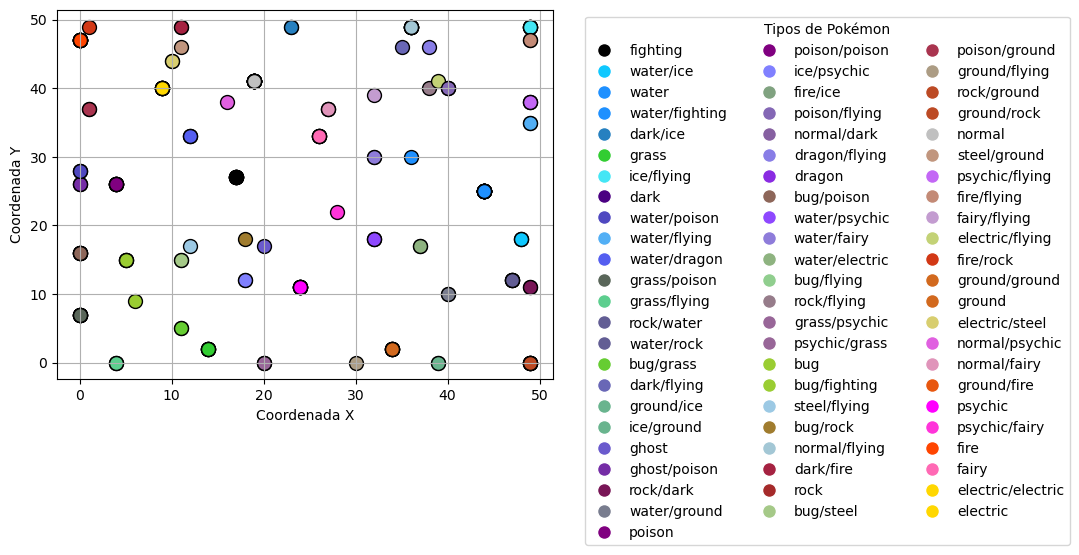

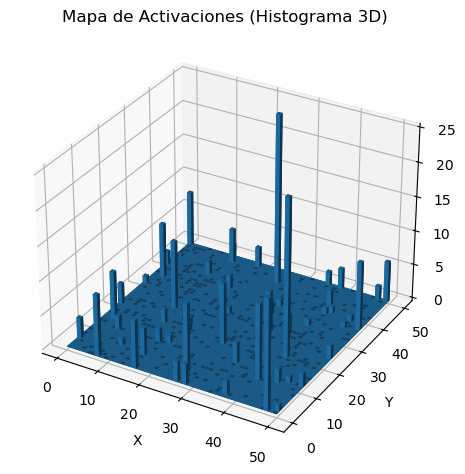

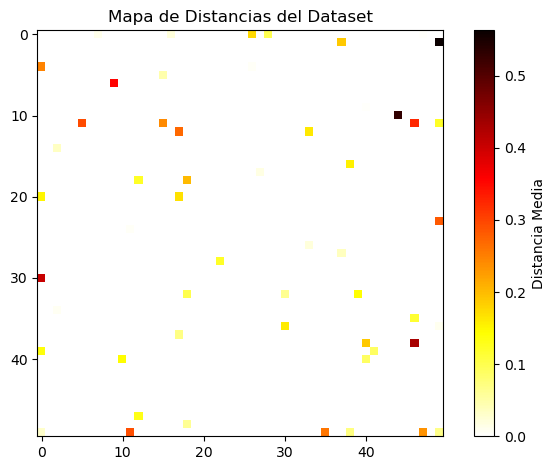

Número de clases identificadas: 56
Error de Cuantificación: 0.063997
Error Topológico: 0.020243


In [ ]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

def clasificar_som(datos, matriz_pesos, calcular_bmu):
    """Clasifica un dataset de patrones usando una matriz de pesos entrenada.

    Args:
        datos: Datos de entrada (num_entradas x num_patrones)
        matriz_pesos: Matriz de pesos entrenada (lado_mapa x lado_mapa x num_entradas)
        calcular_bmu: Función para calcular la BMU

    Returns:
        tuple (mapa_clasificacion, mapa_activaciones, mapa_distancias, num_clases, error_cuantificacion, error_topologico):
            - mapa_clasificacion: Matriz con los patrones clasificados por cada neurona (lado_mapa x lado_mapa x num_entradas)
            - mapa_activaciones: Matriz con el número de patrones reconocidos por cada neurona (lado_mapa x lado_mapa)
            - mapa_distancias: Matriz con la distancia media de los patrones con el vector de pesos (lado_mapa x lado_mapa)
            - num_clases: Número de clases identificadas
            - error_cuantificacion: Error de cuantificación
            - error_topologico: Error topológico
    """

    # Obtenemos las dimensiones de la matriz de pesos
    # y los patrones de entrada
    filas = matriz_pesos.shape[0]
    columnas = matriz_pesos.shape[1]
    dim_entrada = matriz_pesos.shape[2]
    num_patrones = datos.shape[0]  # Número de patrones (segunda dimensión de datos)

    # 1. Definimos las tres matrices y las inicializamos a 0
    # Mapa de clasificación: Guarda el último patrón clasificado en cada neurona
    mapa_clasificacion = np.full((lado_mapa, lado_mapa), ' ')

    # Mapa de activaciones: Guarda el número de patrones reconocidos por cada neurona
    mapa_activaciones = np.zeros([filas, columnas])

    # Mapa de distancias: Guarda la distancia media de los patrones con el vector de pesos
    mapa_distancias = np.zeros([filas, columnas])

    # Sumas totales de cada error
    suma_error_cuantificacion = 0
    suma_error_topologico = 0
    # Vector que contendrá todos los tipos encontrados en el dataset.
    leyenda_tipos = {}

    # 2. Recorremos todo el dataset de patrones de entrada
    for i,patron in enumerate(datos):
        # Obtenemos el patrón actual para clasificar
        patron_actual = patron

        # Calculamos la BMU para el patrón actual
        vector_bmu, coords_bmu = calcular_bmu(patron_actual, matriz_pesos_entrenada, dim_entrada)
        fila_bmu, col_bmu = coords_bmu
        tipo1, tipo2 = tipos_pokemon[i]

        # Unificamos los tipos en uno solo, sabiendo que tipo2 puede estar vacío.
        tipo_completo = f'{tipo1}/{tipo2}' if tipo2 != '-' else tipo1

        # Asignamos un color lógico (por ej. agua-azul) a cada tipo encontrado.
        color1 = tipo_color_dict.get(tipo1, "#000000")
        color2 = tipo_color_dict.get(tipo2, color1)
        # Mezclamos los colores para que el tipo_completo sea de un color que tenga sentido teniendo en cuenta ambos tipos
        # y teniendo en cuenta que el tipo 1 es el predominante.
        color = mezclar_colores_segun_tipo(color1, color2) if tipo1 != tipo2 else color1

        #Vamos creando pokemon a pokemon el mapa de classificación.
        plt.scatter(fila_bmu, col_bmu, color=color, edgecolors='black', s=100)
        if tipo_completo not in leyenda_tipos:
            leyenda_tipos[tipo_completo] = color
        # Calculamos la distancia entre el patrón actual y la BMU actual (error de cuantificación)
        distancia_patron_bmu = np.linalg.norm(matriz_pesos[int(fila_bmu), int(col_bmu)] - patron_actual)**2

        # Actualizamos el mapa de clasificación con el patrón actual
        mapa_clasificacion[fila_bmu, col_bmu] = tipo_completo

        # Incrementamos el contador de activaciones de la BMU
        mapa_activaciones[int(fila_bmu), int(col_bmu)] += 1

        # Añadimos la distancia entre el patrón y la BMU al mapa de distancias
        mapa_distancias[int(fila_bmu), int(col_bmu)] = (
            (mapa_distancias[int(fila_bmu), int(col_bmu)] * (mapa_activaciones[int(fila_bmu), int(col_bmu)] - 1) + distancia_patron_bmu) /
            mapa_activaciones[int(fila_bmu), int(col_bmu)]
        )

        # Añadimos el error de cuantificación al total
        suma_error_cuantificacion += distancia_patron_bmu

        # Calculamos el error topológico
        # Calculamos las distancias a todas las neuronas para el patrón actual
        distancias = np.zeros([filas, columnas])
        for fila in range(filas):
            for columna in range(columnas):
                distancias[fila, columna] = np.linalg.norm(matriz_pesos[fila, columna] - patron_actual)**2

        # Marcamos la BMU como infinito para encontrar la segunda BMU
        # Encontramos la segunda BMU utilizando la misma estrategia que en Forma 1
        distancias_lista = np.array([
            (fila, columna, np.linalg.norm(matriz_pesos[fila, columna] - patron_actual))
            for fila in range(filas)
            for columna in range(columnas)
            if (fila, columna) != (fila_bmu, col_bmu)  # Excluir la BMU principal
        ])
        distancias_lista = distancias_lista[np.argsort(distancias_lista[:, 2])]  # Ordenar por distancia
        bmu2_idx = distancias_lista[0, :2]  # Segunda BMU más cercana
        fila_bmu2, col_bmu2 = int(bmu2_idx[0]), int(bmu2_idx[1])

        # Comprobamos si las dos BMUs son adyacentes
        if (abs(fila_bmu - fila_bmu2) <= 1 and abs(col_bmu - col_bmu2) <= 1):
            # Son adyacentes - no hay error topológico
            suma_error_topologico += 0
        else:
            # No son adyacentes - hay error topológico
            suma_error_topologico += 1

    # Calculamos el número de clases (neuronas activadas)
    num_clases = np.count_nonzero(mapa_activaciones)

    # Calculamos los errores medios
    error_cuantificacion = suma_error_cuantificacion / num_patrones
    error_topologico = suma_error_topologico / num_patrones

    return leyenda_tipos, mapa_clasificacion, mapa_activaciones, mapa_distancias, num_clases, error_cuantificacion, error_topologico

leyenda_tipos, mapa_clasificacion, mapa_activaciones, mapa_distancias, num_clases, error_cuantificacion, error_topologico = clasificar_som(datos, matriz_pesos_entrenada, calcular_bmu)

# 1. Mostramos el Gráfico RGB de los pesos iniciales
#pintar_mapa(matriz_pesos_mejores_parametros_inicial, "Gráfico RGB de los pesos iniciales")

# 2. Mostramos el Gráfico RGB de los pesos entrenados
#pintar_mapa(matriz_pesos_mejores_parametros, "Gráfico RGB de los pesos entrenados")

# 3. Mostramos el mapa de clasificación
tipos_ordenados = sorted(leyenda_tipos.items(), key=lambda x: mcolors.to_rgb(x[1]))  # Ordena según el valor RGB del color

# Crear la leyenda con las entradas ordenadas
leyenda_puntos = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10, label=tipo)
                  for tipo, col in tipos_ordenados]

# Mostrar la leyenda con dos columnas
plt.legend(handles=leyenda_puntos, title="Tipos de Pokémon", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.show()

# 4. Mostramos el histograma 3D del Mapa de Activaciones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(mapa_activaciones.shape[0])
y = np.arange(mapa_activaciones.shape[1])
X, Y = np.meshgrid(x, y)
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(mapa_activaciones).ravel(),
            1, 1, mapa_activaciones.ravel(), shade=True)
ax.set_title("Mapa de Activaciones (Histograma 3D)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Frecuencia")
ax.set_zlabel("Frecuencia", labelpad=10)
plt.tight_layout()
plt.show()

# 5. Mostramos el mapa de distancias
plt.figure()
plt.title("Mapa de Distancias del Dataset")
im = plt.imshow(mapa_distancias, cmap='hot_r')
plt.colorbar(im, label="Distancia Media")
plt.tight_layout()
plt.show()

# 6. Número de clases y errores
print(f"Número de clases identificadas: {num_clases}")
print(f"Error de Cuantificación: {error_cuantificacion:.6f}")
print(f"Error Topológico: {error_topologico:.6f}")


## SOM Prueba

El proceso de prueba es la fase en la que evaluamos cómo se comporta la red con datos nuevos después del entrenamiento. En esta fase, no actualizamos los pesos, si no que analizamos cómo la red clasifica los nuevos datos.

Los objetivos de la fase de prueba son:
* **Evaluar la calidad de la clasificación** $\rightarrow$ Verificar si la red ha aprendido correctamente las características de los datos y es capaz de generalizar y organizar nuevos datos.
* **Observar la estructura de los datos** $\rightarrow$ Ver cómo los patrones de entrada se asignan a las neuronas y cómo se organizan en el mapa.
* **Identificar errores** $\rightarrow$ Ver si hay datos mal clasificados y entender por qué la red ha cometido errores utilizando el error de cuantificación y el error topológico.

Como hemos mencionado anteriormente, en la fase de prueba no se actualizan los pesos del SOM. Los pasos a seguir son:
1. **Presentación de nuevos datos** $\rightarrow$ Presentamos un conjunto nuevo de datos que el SOM no ha visto durante el entrenamiento. Cada dato de entrada es un vector de características similares a los datos de entrenamiento.
2. **Cálculo de la BMU** $\rightarrow$ Para cada dato de entrada, buscamos la mejor neurona (BMU) que representa mejor las características del dato.
3. **Asignación de la clase** $\rightarrow$ Asignamos qué neurona del SOM ha reconocido cada dato. 
4. **Análisis de los resultados** $\rightarrow$ Analizamos cómo se han clasificado los datos y si hay errores mediante el error topológico (indica si los datos similares se asignan a neuronas adyacentes) y el mapa de clasificación (muestra dónde se han asignado los datos de prueba en el som).

Las diferencias entre las fases de entrenamiento, clasificación y prueba son las siguientes:

| **Fase**                        | **SOM de Entrenamiento**            | **SOM de Clasificación**                    | **SOM de Prueba**                       |
|---------------------------------|-------------------------------------|---------------------------------------------|-----------------------------------------|
| **Se le muestran datos nuevos** | No (usa datos de entrenamiento)     | No (usa los mismos datos del entrenamiento) | Sí (se prueban datos no vistos)         |
| **Modifica pesos**              | Sí (ajusta los pesos)               | No (solo asigna patrones)                   | No (solo analiza datos nuevos)          |
| **Encuentra BMU**               | Sí                                  | Sí                                          | Sí                                      |
| **Ajusta la vecindad**          | Sí (disminuye con el tiempo)        | No                                          | No                                      |
| **Calcula errores**             | Sí (para optimizar el aprendizaje)  | Sí (para evaluar la clasificación)          | Sí (para medir la generalización)       |
| **Objetivo**                    | Aprender la estructura de los datos | Organizar datos entrenados                  | Evaluar el rendimiento con datos nuevos |


In [ ]:
# Clasifica nuevos patrones (pokemon_classify)

dataset_clasi = "/pokemon_classify.csv"
datos_clasificar_original = pd.read_csv(dataset_clasi)
"""Contiene todos los datos de clasificacion de nuevos Pokemons"""

tipos_pokemon = datos_clasificar_original[['type1', 'type2']].fillna('-').to_numpy()

columnas_relevantes = [col for col in datos_original.columns if "against_" in col]
datos_clasificar = datos_clasificar_original[columnas_relevantes].values
"""Filtramos obteniendo únicamente las columnas de cómo reaccionan ante los ataques de los tipos de Pokemon"""

valor_maximo = datos_clasificar.max(axis=0)
"""Valor máximo de los datos de entrada"""

if normalizar_datos:
    # Escalamos los datos al rango [0, 1]
    datos_clasificar = datos_clasificar / np.max(valor_maximo)

leyenda_tipos, mapa_clasificacion, mapa_activaciones, mapa_distancias, num_clases, error_cuantificacion, error_topologico = clasificar_som(datos_clasificar, matriz_pesos_entrenada, calcular_bmu)

# 3. Mostramos el mapa de clasificación
tipos_ordenados = sorted(leyenda_tipos.items(), key=lambda x: mcolors.to_rgb(x[1]))  # Ordena según el valor RGB del color

# Crear la leyenda con las entradas ordenadas
leyenda_puntos = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10, label=tipo)
                  for tipo, col in tipos_ordenados]

# Mostrar la leyenda con dos columnas
plt.legend(handles=leyenda_puntos, title="Tipos de Pokémon", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.show()

# 4. Mostramos el histograma 3D del Mapa de Activaciones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(mapa_activaciones.shape[0])
y = np.arange(mapa_activaciones.shape[1])
X, Y = np.meshgrid(x, y)
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(mapa_activaciones).ravel(),
            1, 1, mapa_activaciones.ravel(), shade=True)
ax.set_title("Mapa de Activaciones (Histograma 3D)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Frecuencia")
ax.set_zlabel("Frecuencia", labelpad=10)
plt.tight_layout()
plt.show()

# 5. Mostramos el mapa de distancias
plt.figure()
plt.title("Mapa de Distancias del Dataset")
im = plt.imshow(mapa_distancias, cmap='hot_r')
plt.colorbar(im, label="Distancia Media")
plt.tight_layout()
plt.show()

# 6. Número de clases y errores
print(f"Número de clases identificadas: {num_clases}")
print(f"Error de Cuantificación: {error_cuantificacion:.6f}")
print(f"Error Topológico: {error_topologico:.6f}")

Como podemos observar, la red ha clasificado de forma efectiva los 4 pokemos del data set de clasificación. 
- Pikachu se clasifica en el tipo electric en la zona en la que cayeron los pokemons de tipo eléctrico en el apartado de clasificación
- Articuno y Moltres pertenecen a la misma zona por dos motivos. El primero es que sus datos de daño recibido por otros tipos son bastante similares, con alguna diferencia, pero mínima: 
    - Articuno: 0.5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,0.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0
    - Moltres: 0.25,1.0,1.0,2.0,0.5,0.5,0.5,1.0,1.0,0.25,0.0,1.0,1.0,1.0,1.0,4.0,0.5,2.0
    - BMU asignada a los dos: 
   Por otro lado, la red clasifica a ambos en el mismo grupo porque ambos tienen el mismo tipo2, y aunque previamente hemos establecido que el tipo1 es el primario, el que sean ambos de 'flying' influye lo suficiente como para que estén en la misma clase. 
- Slowbro está clasificado cerca del grupo de water/psyquic que se formo en el apartado de Clasificación. Vemos en ese mapa que está cerca de todos los tipos relacionados con water y psyquic.